# Comparison of two sets

## Input json format

```
data = {
            "n_photons": Nphotons,
            "overflow": cube_overflow,
            "bins_per_1_cm": bins_per_1_cm,
            "mu_a": mu_a,
            "overflow": overflow,
            "cube": Cube
        }
```

## Load data from json

In [13]:
import json
import numpy as np
import matplotlib.pyplot as plt

benchmark = filename_my_100mln_cube

pairs to compare:
1. filename_org_1mld_cube - filename_my_100mln_cube
2. filename_my_1mln_cube - filename_my_100mln_cube
3. filename_mati_cube - filename_my_100mln_cube

In [2]:
def load_from_file(filename):
    file = open(filename, 'r')
    data = json.load(file)
    file.close()
    return data


filename_mati_cube = "mati_cube.json"
filename_my_1mln_cube = "mc456_mc_1mln_my_params_cube.json"
# !!!!!!!!!!!!!!! TO CHANGE !!!!!!!!!!!!!!! NAME 100 MLN
filename_my_100mln_cube = "mc456_mc_10mln_my_params_cube.json"
filename_org_1mld_cube = "mc456_mc_1mld_original_params_cube.json"

mati_cube = load_from_file(filename_mati_cube)
my_1mln_cube = load_from_file(filename_my_1mln_cube)
my_100mln_cube = load_from_file(filename_my_100mln_cube)
org_1mld_cube = load_from_file(filename_org_1mld_cube)

mati_cube['mu_a'] = 0.37
my_1mln_cube['mu_a'] = 0.37
my_100mln_cube['mu_a'] = 0.37
org_1mld_cube['mu_a'] = 1.0

In [3]:
all_cubes = [mati_cube, my_1mln_cube, my_100mln_cube, org_1mld_cube]
all_cubes_names = ['mati_cube', 'my_1mln_cube', 'my_100mln_cube', 'org_1mld_cube']

for cub, name in zip(all_cubes, all_cubes_names):
    cub['name'] = name
    cub['photon_weight'] = 1.0

In [ ]:
def cube_list2array(d):
    d['cube'] = np.asarray(d['cube'])


for cub in all_cubes:
    print(type(cub['cube']))
    cube_list2array(cub)
    print(type(cub['cube']))

## Experiment

<img src="../mati_sim/mati_propEnv.png" alt="comparing methods" width="300"/>

Axes are:<br>
*x=red, y=green, z=blue*

## Data statistics

In [5]:
print("shape", all_cubes[0]['cube'].shape)
print("size", all_cubes[0]['cube'].size)

shape (180, 180, 240)
size 7776000


           Name            Sum            Sum       Avg         Median            min            max             q0          q0_25          q0_50          q0_75             q1            std       variance       Overflow       perc. in      n_photons  non_zero_vals
      mati_cube      2071459.6      2071459.6      0.27           0.08            0.0       14260.86            0.0           0.02           0.08           0.22       14260.86          12.04         145.07     2598810.67          44.35        1000000        6191127
   my_1mln_cube     2379004.49     2379004.21      0.31           0.12            0.0       13463.06            0.0           0.04           0.12           0.27       13463.06          10.09         101.72     2291266.06          50.94        1000000        7653406
 my_100mln_cube     2378682.57     2378682.43      0.31           0.13            0.0       13419.53            0.0           0.05           0.13           0.26       13419.53          10.07         101

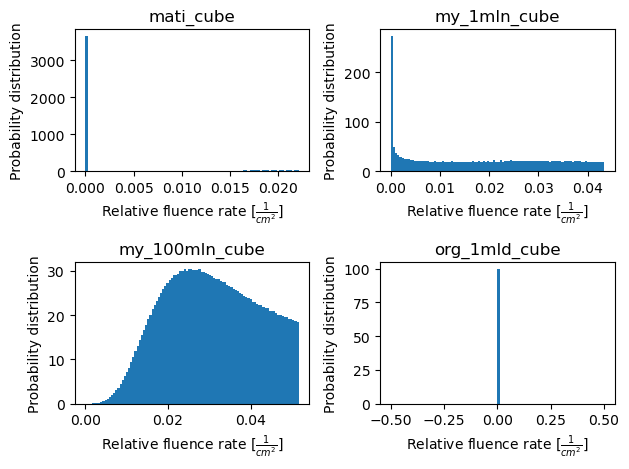

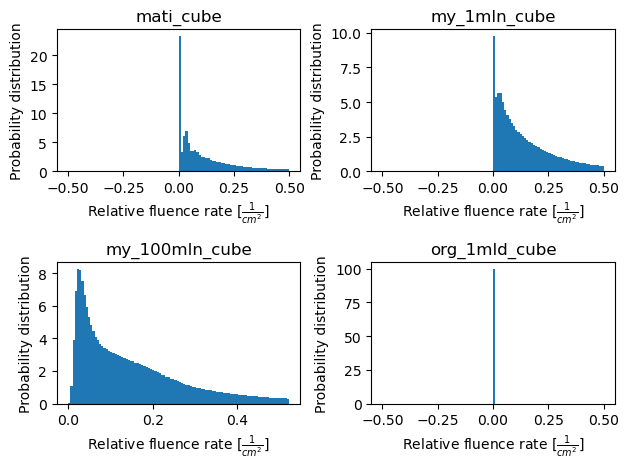

In [25]:
def print_stats(cub_list, cub_arr_list=None):
    print(f"{'Name' : >15}{'Sum' : >15}{'Sum' : >15}{'Avg' : >10}{'Median' : >15}{'min' : >15}{'max' : >15}{'q0' : >15}{'q0_25' : >15}{'q0_50' : >15}{'q0_75' : >15}{'q1' : >15}{'std' : >15}{'variance' : >15}{'Overflow' : >15}{'perc. in' : >15}{'n_photons' : >15}{'non_zero_vals' : >15}")
    for i in range(len(cub_list)):
        cub = cub_list[i]
        if (cub_arr_list is None):
            cub_arr = cub['cube']
        else:
            cub_arr = cub_arr_list[i]
        n_phot = cub['n_photons']
        ovf = cub['overflow']
        s = cub_arr.sum()
        s2 = n_phot * cub['photon_weight'] - ovf
        avg = np.average(cub_arr)
        me = np.median(cub_arr)
        min = np.min(cub_arr)
        max = np.max(cub_arr)
        q0 = np.quantile(cub_arr, q=0.0)
        q0_25 = np.quantile(cub_arr, q=0.25)
        q0_50 = np.quantile(cub_arr, q=0.50)
        q0_75 = np.quantile(cub_arr, q=0.75)
        q1 = np.quantile(cub_arr, q=1.0)
        std = np.std(cub_arr)
        var = np.var(cub_arr)
        perc = s / (s + ovf) * 100
        non_zero_vals = cub_arr.size - np.isclose(cub_arr, 0).sum()
        # to_round = [ovf, s, s2, avg, me, perc]
        ovf = np.round(ovf, 2)
        s = np.round(s, 2)
        s2 = np.round(s2, 2)
        avg = np.round(avg, 2)
        me = np.round(me, 2)
        min = np.round(min, 2)
        max = np.round(max, 2)
        q0 = np.round(q0, 2)
        q0_25 = np.round(q0_25, 2)
        q0_50 = np.round(q0_50, 2)
        q0_75 = np.round(q0_75, 2)
        q1 = np.round(q1, 2)
        std = np.round(std, 2)
        var = np.round(var, 2)
        perc = np.round(perc, 2)
        print(f"{cub['name'] : >15}{s : >15}{s2 : >15}{avg : >10}{me : >15}{min : >15}{max : >15}{q0 : >15}{q0_25 : >15}{q0_50 : >15}{q0_75 : >15}{q1 : >15}{std : >15}{var : >15}{ovf : >15}{perc : >15}{n_phot : >15}{non_zero_vals : >15}")


def histogram(cub_list, cub_arr_list=None, q_list=None):
    f,a = plt.subplots(2,2)
    a = a.ravel()
    for i in range(len(cub_list)):
        if (cub_arr_list is None):
            cub_arr = cub_list[i]['cube']
        else:
            cub_arr = cub_arr_list[i]
        hist_bins = 100
        density = True
        # histogram = np.histogram(cub_arr, bins=hist_bins, density=density)
        # print("histogram: ", histogram)

        ax = a[i]
        if q_list is None:
            q_val = 0.25
        else:
            q_val = q_list[i]
        q = np.quantile(cub_arr, q=q_val)
        rng = (0, q)
        ax.hist(cub_arr.flatten(), range=rng, bins=hist_bins, density=density)
        ax.set_title(cub_list[i]['name'])
        ax.set_xlabel(r"Relative fluence rate [$\frac{1}{cm^2}$]")
        ylabel = "Probability distribution"
        ax.set_ylabel(ylabel)
    plt.tight_layout()


print_stats(all_cubes)
print()
print('quantile: ', 0.25)
histogram(all_cubes)
q_list = [0.01, 0.01, 0.9, 0.001]
print('quantiles: ', q_list)
histogram(all_cubes, q_list=q_list)

## Normalization

normalization in *mc321.c*<br>
Fsph = Csph[ir]/Nphotons/shellvolume/mua;
[1/cm2]

In [7]:
def normalization(d):
    # bins_per_1_cm = 120
    # mu_a = 0.37
    # n_photons = 1_000_000
    # val = val * 4.67
    bin_size_in_cm = 1 / d['bins_per_1_cm']
    bin_volume = (bin_size_in_cm)**3
    multi = 1 / (d['n_photons'] * bin_volume * d['mu_a'])
    d['cube'] = d['cube'] * multi
    d['overflow'] = d['overflow'] * multi
    d['photon_weight'] = d['photon_weight'] * multi


for c in all_cubes:
    normalization(c)

print_stats(all_cubes)

           Name            Sum            Sum       Avg         Median            std       variance       Overflow       perc. in      n_photons  non_zero_vals
      mati_cube      2071459.6      2071459.6      0.27           0.08          12.04         145.07     2598810.67          44.35        1000000        6191127
   my_1mln_cube     2379004.49     2379004.21      0.31           0.12          10.09         101.72     2291266.06          50.94        1000000        7653406
 my_100mln_cube     2378682.57     2378682.43      0.31           0.13          10.07         101.46     2291587.84          50.93       10000000        7776000
  org_1mld_cube     1494134.04     1494134.04      0.19            0.0          39.64        1571.67      233865.96          86.47     1000000000            239


## Methods

<!-- <img src="mati_benchmark_methods2.png" alt="comparing methods" width="900"/> -->
<img src="../mati_benchmark_methods2.png" alt="comparing methods" width="900"/>
<!-- ![comparing methods](mati_benchmark_methods2.png) -->

There are 3 ways to compare:
1. 1:1 whole 3D array, element-wise
2. x_high (sum and slices)
3. z_high (sum and slices)

In [ ]:
# d1 - takes one dimension (flattened)

def d1_testy_solo(vec1d):
    s = np.sum(vec1d)
    avg = np.average(vec1d)
    me = np.median(vec1d)
    std = np.std(vec1d)
    var = np.var(vec1d)
    histogram = np.histogram(vec1d, bins=10, density=True)
    print(f"{'Sum' : >15}{'Average' : >15}{'Median' : >15}{'Std' : >10}{'Variance' : >15}")
    print(f"{s : >15}{avg : >15}{me : >15}{std : >10}{var : >15}")
    print("histogram: ", histogram)


def d1_compare2arrays():
    korelacja
    chi2
    mutual information
    różnica
        testy_solo(różnica)







flatten
    testy_solo(każdy)
    compare2arrays(kazdy do benchmarka)
    


histogram 3d





make_frames
show_frames









NOTEBOOK porównywanie dwóch ze sobą
    3 metody z obrazka
        porównać wizualnie
        porównać wartości
        miary statystyczne

    plot czasówek
    plot jak zmieniają się miary wraz z wzrostem photons



### 1. 1:1 whole 3D array, element-wise

In [8]:
mati_array = np.asarray(mati_cube["cube"])
t1_array = np.asarray(t1_cube["cube"])

In [12]:
a = mati_array[20,30,61]
b = mati_cube["cube"][20][30][61]
print(a)
print(b)

0.020606858153521874
0.020606858153521874


0.020606858153521874

In [7]:
mati_array.shape

(180, 180, 240)

### 2. z_high (sum and slices)

### 3. x_high (sum and slices)